<a href="https://colab.research.google.com/github/Nayoung-young/project_lifetimevalue/blob/main/e_commerce_LTV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# _0.라이브러리 임포트

In [ ]:
!pip install plotly
!pip install Lifetimes
!pip install nb_black

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.2/584.2 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 15.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
import pandas as pd # python에서의 엑셀과 같은 역할
import numpy as np # 계산을 편하게 해 주는 라이브러리
import matplotlib as mpl
import matplotlib.pyplot as plt # 시각화
import seaborn as sns # 시각화
import math

import matplotlib.ticker as ticker # 시각화
import matplotlib.dates as mdates # 시각화

import warnings

warnings.filterwarnings('ignore')
sns.set_theme(style='white')

# from other 
import matplotlib.colors as mcolors
from sklearn.metrics import (silhouette_score,
                             calinski_harabasz_score,
                             davies_bouldin_score)
%matplotlib inline
sns.set_style('whitegrid')
palette = 'Set2'

# sns.set(font_scale=2)

# _1. 데이터 불러오기 

In [ ]:
%%time
df = pd.read_csv('/content/e-commerce_LTV.csv', encoding= 'unicode_escape')
df_base = df.copy()

CPU times: user 1.17 s, sys: 237 ms, total: 1.41 s
Wall time: 2.29 s


In [ ]:
df_base.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [ ]:
df_base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [ ]:
len(df_base['InvoiceNo'].unique().tolist()) # InvoiceNo가 primary key인가? -> Nope 

25900

In [ ]:
print(min(df_base['Quantity'].tolist()))
print(max(df_base['Quantity'].tolist())) # Quantity 범위 확인 

-80995
80995


In [ ]:
quantity = df_base['Quantity'].tolist() 

print(len(list(filter(lambda x: x < 0, quantity)))) # quantity < 0 인 경우 
print(len(list(filter(lambda x: x > 0, quantity)))) # quantity > 0 인 경우 

10624
531285


In [ ]:
sum(df_base['Quantity'].dropna())

5176450

In [ ]:
df_base['Country'].unique().tolist() # Country 고유값

['United Kingdom',
 'France',
 'Australia',
 'Netherlands',
 'Germany',
 'Norway',
 'EIRE',
 'Switzerland',
 'Spain',
 'Poland',
 'Portugal',
 'Italy',
 'Belgium',
 'Lithuania',
 'Japan',
 'Iceland',
 'Channel Islands',
 'Denmark',
 'Cyprus',
 'Sweden',
 'Austria',
 'Israel',
 'Finland',
 'Bahrain',
 'Greece',
 'Hong Kong',
 'Singapore',
 'Lebanon',
 'United Arab Emirates',
 'Saudi Arabia',
 'Czech Republic',
 'Canada',
 'Unspecified',
 'Brazil',
 'USA',
 'European Community',
 'Malta',
 'RSA']

In [ ]:
# df_base.groupby(['Country']).agg(country_cnt = ('Country', 'count')).reset_index().sort_values(by = 'country_cnt', ascending =False)

#_1. 데이터 전처리

In [ ]:
df_base.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

## 1.1 컬럼명 바꾸기 

In [ ]:
# 컬럼 이름 snake case 로 rename 
%%time
df_base.rename(columns = {'InvoiceNo':'invoice_no', 
                        'StockCode':'stock_code', 
                        'Quantity': 'quantity',
                        'Description':'description',
                        'InvoiceDate': 'invoice_date',
                        'UnitPrice': 'unit_price', 
                        'CustomerID': 'customer_id', 
                        'Country':'country'}, inplace = True)

CPU times: user 775 µs, sys: 0 ns, total: 775 µs
Wall time: 783 µs


In [ ]:
LTV_columns = ['invoice_no', 'stock_code', 'quantity', 'invoice_date', 'unit_price', 'customer_id']
df_LTV = df_base[LTV_columns]

In [ ]:
df_LTV.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   invoice_no    541909 non-null  object 
 1   stock_code    541909 non-null  object 
 2   quantity      541909 non-null  int64  
 3   invoice_date  541909 non-null  object 
 4   unit_price    541909 non-null  float64
 5   customer_id   406829 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 24.8+ MB


## 1.2 결측값 처리 
- customer_id: 
  - 결측값 = 비회원으로 추정
  - 추후 LTV 계산에서 활용하지는 않을 것이지만 fillna(0)
  - object로 타입 변환 

In [ ]:
df_LTV_01 = df_LTV.copy()

In [ ]:
## customer_id type 변환해도될지 체크 
%%time 
list(filter(lambda x: str(x)[-1] != '0', df_LTV_01['customer_id'].unique().tolist()))

CPU times: user 8.82 ms, sys: 5.22 ms, total: 14 ms
Wall time: 13.1 ms


[nan]

In [ ]:
df_LTV_01['customer_id'].isna().sum() # customer_id 결측값 확인 

135080

In [ ]:
df_LTV_01.sample(5)

,invoice_no,stock_code,quantity,invoice_date,unit_price,customer_id
245850,558635,22982,3,6/30/2011 19:52,1.25,16498.0
402709,571508,22219,2,10/17/2011 15:27,1.63,NaN
48932,540482,22727,1,1/7/2011 15:48,3.75,14672.0
227737,556905,20658,1,6/15/2011 13:05,1.25,16904.0
516861,579990,82494L,18,12/1/2011 11:20,2.95,14804.0


In [ ]:
df_LTV_01[df_LTV_01['invoice_no'] == '536865' ] # 비회원으로 추정, LTV 계산에서 활용 불가 

,invoice_no,stock_code,quantity,invoice_date,unit_price,customer_id
5546,536865,10002,5,12/3/2010 11:28,1.66,NaN
5547,536865,15056bl,2,12/3/2010 11:28,12.72,NaN
5548,536865,18098c,7,12/3/2010 11:28,5.06,NaN
5549,536865,20615,1,12/3/2010 11:28,4.21,NaN
5550,536865,20655,1,12/3/2010 11:28,2.51,NaN
...,...,...,...,...,...,...
5681,536865,85099B,1,12/3/2010 11:28,4.21,NaN
5682,536865,85152,1,12/3/2010 11:28,4.21,NaN
5683,536865,85176,1,12/3/2010 11:28,1.66,NaN
5684,536865,M,1,12/3/2010 11:28,2.55,NaN


In [ ]:
df_LTV_01['customer_id'] = df_LTV_01['customer_id'].fillna(0)

In [ ]:
df_LTV_01['customer_id'].isna().sum() # customer_id

0

In [ ]:
%%time 
df_LTV_01 = df_LTV_01.astype({'customer_id' : 'int'}) # float 였으므로 .0 없애기 위해 먼저 int로 변환 
df_LTV_01 = df_LTV_01.astype({'customer_id' : 'object'})

CPU times: user 28 ms, sys: 37.6 ms, total: 65.6 ms
Wall time: 69 ms


In [ ]:
df_LTV_01.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   invoice_no    541909 non-null  object 
 1   stock_code    541909 non-null  object 
 2   quantity      541909 non-null  int64  
 3   invoice_date  541909 non-null  object 
 4   unit_price    541909 non-null  float64
 5   customer_id   541909 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 24.8+ MB


## 1.3 invoice_date
- 현재 type: object -> datetime으로 변경 

In [ ]:
df_LTV_01.sample(10)

,invoice_no,stock_code,quantity,invoice_date,unit_price,customer_id
427924,573405,21132,1,10/30/2011 15:55,4.25,13822
223788,556491,22789,2,6/12/2011 14:15,1.95,16794
279623,561352,23077,40,7/26/2011 14:41,1.25,18094
4437,536782,22469,24,12/2/2010 15:18,1.65,17567
166962,550958,85123A,6,4/21/2011 16:37,2.95,15281
41638,539953,22631,1,12/23/2010 12:03,1.95,12748
239304,558042,22726,4,6/24/2011 13:26,3.75,13870
137848,548169,22384,20,3/29/2011 13:48,1.65,14680
534497,581149,22107,1,12/7/2011 14:12,1.25,15471
373831,569363,21755,6,10/3/2011 15:08,6.25,13297


In [ ]:
df_LTV_01['invoice_date'] = pd.to_datetime(df_LTV_01['invoice_date'], format = '%m/%d/%Y %H:%M')

In [ ]:
df_LTV_01.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   invoice_no    541909 non-null  object        
 1   stock_code    541909 non-null  object        
 2   quantity      541909 non-null  int64         
 3   invoice_date  541909 non-null  datetime64[ns]
 4   unit_price    541909 non-null  float64       
 5   customer_id   541909 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 24.8+ MB


In [ ]:
# date관련 데이터 추가하기: 월 정보
df_LTV_01['invoice_year'] = df_LTV_01['invoice_date'].dt.year
df_LTV_01['invoice_month'] = df_LTV_01['invoice_date'].dt.month
df_LTV_01['invoice_day'] = df_LTV_01['invoice_date'].dt.day

df_LTV_01.head()

,invoice_no,stock_code,quantity,invoice_date,unit_price,customer_id,invoice_year,invoice_month,invoice_day
0,536365,85123A,6,2010-12-01 08:26:00,2.55,17850,2010,12,1
1,536365,71053,6,2010-12-01 08:26:00,3.39,17850,2010,12,1
2,536365,84406B,8,2010-12-01 08:26:00,2.75,17850,2010,12,1
3,536365,84029G,6,2010-12-01 08:26:00,3.39,17850,2010,12,1
4,536365,84029E,6,2010-12-01 08:26:00,3.39,17850,2010,12,1


#_2. 파악을 위한 시각화 

**[ 변수 정보 ]**
*   InvoiceNo: Invoice number that consists 6 digits. If this code starts with letter 'c', it indicates a cancellation.
*   StockCode: Product code that consists 5 digits.
*   Description: Product name.
*   Quantity: The quantities of each product per transaction.
*   InvoiceDate: Represents the day and time when each transaction was generated.
*   CustomerID: Customer number that consists 5 digits. Each customer has a unique customer ID.
*   Country: Name of the country where each customer resides.


In [ ]:
# 시각화 라이브러리 
import plotly.graph_objs as go
from plotly.offline import iplot

In [ ]:
world_map = df_base[['customer_id', 'invoice_no', 'country']
              ].groupby(['customer_id', 'invoice_no', 'country']
                       ).count().reset_index()

countries = world_map['country'].value_counts()

data = dict(type='choropleth',
            locations = countries.index,
            locationmode = 'country names',
            z = countries,
            text = countries.index,
            colorbar = {'title':'Orders'},
            colorscale='Viridis',
            reversescale = False)

layout = dict(title={'text': "Number of Orders by Countries",
                     'y':0.9,
                     'x':0.5,
                     'xanchor': 'center',
                     'yanchor': 'top'},
              geo = dict(resolution = 50,
                         showocean = True,
                         oceancolor = "LightBlue",
                         showland = True,
                         landcolor = "whitesmoke",
                         showframe = True),
             template = 'plotly_white',
             height = 600,
             width = 1000)

choromap = go.Figure(data = [data], layout = layout)
iplot(choromap, validate = False)

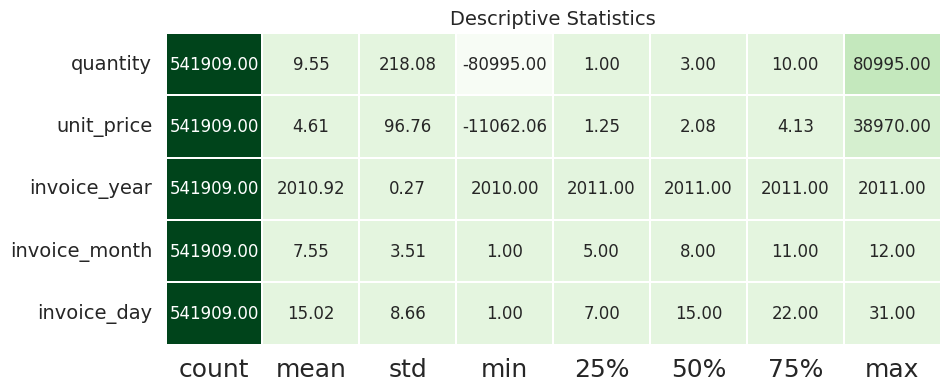

In [ ]:
def desc_stats(dataframe):
    desc_df = pd.DataFrame(index= dataframe.columns, 
                           columns= dataframe.describe().T.columns,
                           data= dataframe.describe().T)
    
    f,ax = plt.subplots(figsize=(10,
                                 desc_df.shape[0] * 0.81))
    sns.heatmap(desc_df,
                annot = True,
                cmap = "Greens",
                fmt = '.2f',
                ax = ax,
                linecolor = 'white',
                linewidths = 1.1,
                cbar = False,
                annot_kws = {"size": 12})
    plt.xticks(size = 18)
    plt.yticks(size = 14,
               rotation = 0)
    plt.title("Descriptive Statistics", size = 14)
    plt.show()
    
desc_stats(df_LTV_01.select_dtypes(include = [float, int]))

* 취소된 주문내역 때문에 quantity(unit_price) < 0인 row 존재 
* total_price = quantity * unit_price로 구할 예정 

## 2.1 추가 전처리 (여기서부터 다시 시작하기)
- quantity, unit_price 

In [ ]:
df_LTV_01[df_LTV_01['quantity'] < 0].sample(5)

,invoice_no,stock_code,quantity,invoice_date,unit_price,customer_id,invoice_year,invoice_month,invoice_day
283467,C561725,82581,-1,2011-07-29 12:10:00,0.55,17841,2011,7,29
90365,C544034,22197,-1,2011-02-15 11:28:00,0.85,14701,2011,2,15
381256,C569851,22605,-1,2011-10-06 14:02:00,12.75,17511,2011,10,6
468155,C576393,21891,-6,2011-11-15 10:34:00,0.72,13735,2011,11,15
159851,C550365,22398,-60,2011-04-18 11:31:00,1.25,12731,2011,4,18


In [ ]:
df_LTV_01.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   invoice_no     541909 non-null  object        
 1   stock_code     541909 non-null  object        
 2   quantity       541909 non-null  int64         
 3   invoice_date   541909 non-null  datetime64[ns]
 4   unit_price     541909 non-null  float64       
 5   customer_id    541909 non-null  object        
 6   invoice_year   541909 non-null  int64         
 7   invoice_month  541909 non-null  int64         
 8   invoice_day    541909 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(4), object(3)
memory usage: 37.2+ MB


In [ ]:
df_LTV_01[df_LTV_01['unit_price'] < 0]

,invoice_no,stock_code,quantity,invoice_date,unit_price,customer_id,invoice_year,invoice_month,invoice_day
299983,A563186,B,1,2011-08-12 14:51:00,-11062.06,0,2011,8,12
299984,A563187,B,1,2011-08-12 14:52:00,-11062.06,0,2011,8,12


In [ ]:
# quantity < 0 이면 unit_price <0 인가? 




#_3. Life Time Value (고객 생애가치) 계산 